<a href="https://colab.research.google.com/github/chobbong/AI18_ChoYunSeo_Section2/blob/main/AI18_choyunseo_section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pandas_datareader.data as pdr
import yfinance as yf
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

2.0.0+cu118
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import datetime
import pandas as pd
import yfinance as yfSliding
from pandas_datareader import data as pdr

def calculate_simple_moving_average(data, window_size):
    sma = data['Close'].rolling(window=window_size).mean()
    return sma

def calculate_exponential_moving_average(data, window_size):
    ema = data['Close'].ewm(span=window_size, adjust=False).mean()
    return ema

# MACD 값을 계산
def calculate_macd(data): 
    ema_12 = calculate_exponential_moving_average(data, 12)
    ema_26 = calculate_exponential_moving_average(data, 26)
    macd = ema_12 - ema_26
    return macd

def calculate_macd_signal(data, macd):
    macd_signal = macd.ewm(span=9, adjust=False).mean()
    return macd_signal

yf.pdr_override()

start = (2000,1,4)
start = datetime.datetime(*start)
end = datetime.date.today()

data = pdr.get_data_yahoo("MSFT", start, end)

# 5일, 20일, 60일 단순 이동 평균선을 계산합니다.
sma_5 = calculate_simple_moving_average(data, 5)
sma_20 = calculate_simple_moving_average(data, 20)
sma_60 = calculate_simple_moving_average(data, 60)

# 단순 이동 평균선 결과를 Pandas DataFrame에 추가합니다.
data['SMA_5'] = sma_5
data['SMA_20'] = sma_20
data['SMA_60'] = sma_60

# MACD와 신호선을 계산합니다.
macd = calculate_macd(data)
macd_signal = calculate_macd_signal(data, macd)

# 결과를 Pandas DataFrame에 추가합니다.
data['MACD'] = macd
data['MACD_Signal'] = macd_signal

data = pd.DataFrame(data)
print(data)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2000-01-04   56.781250   58.562500   56.125000   56.312500   35.133274   
2000-01-05   55.562500   58.187500   54.687500   56.906250   35.503719   
2000-01-06   56.093750   56.937500   54.187500   55.000000   34.314404   
2000-01-07   54.312500   56.125000   53.656250   55.718750   34.762833   
2000-01-10   56.718750   56.843750   55.687500   56.125000   35.016289   
...                ...         ...         ...         ...         ...   
2023-04-04  287.230011  290.450012  285.670013  287.179993  287.179993   
2023-04-05  285.850006  287.149994  282.920013  284.339996  284.339996   
2023-04-06  283.209991  292.079987  282.029999  291.600006  291.600006   
2023-04-10  289.209991  289.600006  284.709991  289.390015  289.390015   
2023-04-11  285.750000  285.980011  281.640

In [ ]:
data = data.dropna(axis=0)

In [ ]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_20,SMA_60,MACD,MACD_Signal
Date,,,,,,,,,,,
2023-04-04,287.230011,290.450012,285.670013,287.179993,287.179993,25824300,285.453998,272.290002,257.890668,7.923587,6.731802
2023-04-05,285.850006,287.149994,282.920013,284.339996,284.339996,22064800,286.219995,273.822002,258.844334,7.701957,6.925833
2023-04-06,283.209991,292.079987,282.029999,291.600006,291.600006,29770300,287.729999,275.786002,259.890168,8.019689,7.144604
2023-04-10,289.209991,289.600006,284.709991,289.390015,289.390015,23103000,287.948004,277.826003,260.783835,8.000937,7.315871
2023-04-11,285.750000,285.980011,281.640015,282.829987,282.829987,27254900,287.067999,279.271503,261.522501,7.371759,7.327048


In [ ]:
data.isna().sum()

Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
SMA_5          0
SMA_20         0
SMA_60         0
MACD           0
MACD_Signal    0
dtype: int64

<Axes: xlabel='Date'>

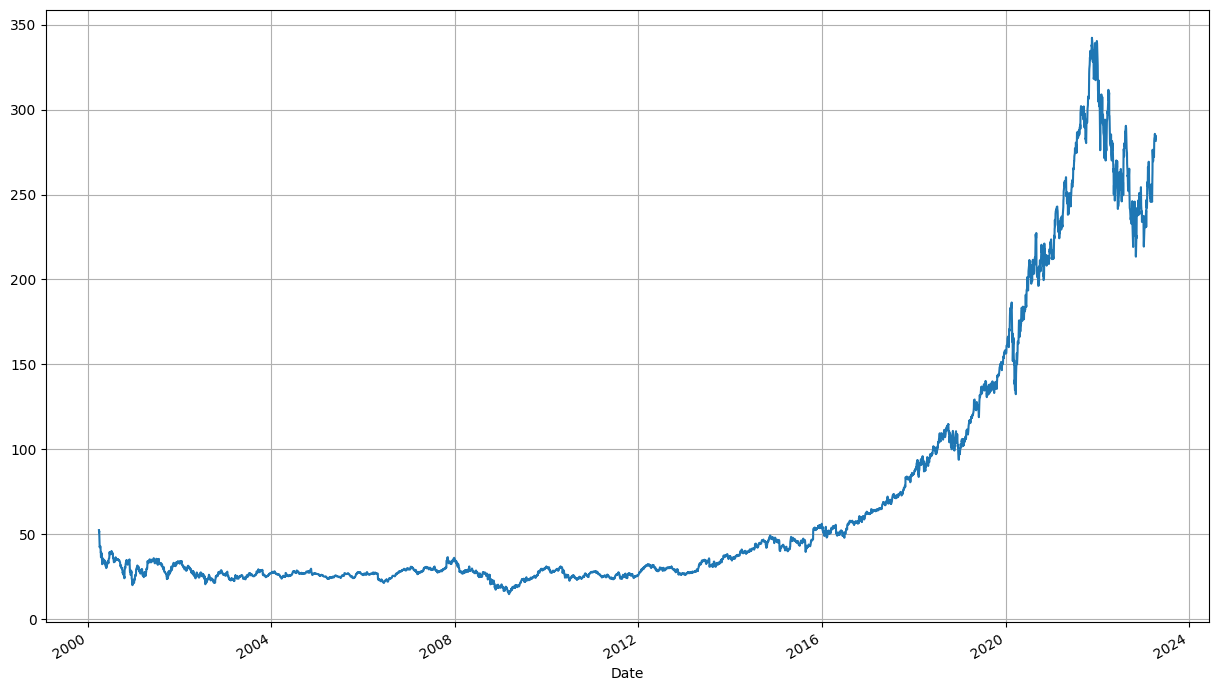

In [ ]:
data.Low.plot(grid=True)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# 조건 1. 데이터셋을 나누자: train, validation, test set
def create_dataset(data, n_past, n_future):
    X, y = [], []
    for i in range(n_past, len(data) - n_future):
        X.append(data[i - n_past:i])
        y.append(data[i:i + n_future, 0])
    return np.array(X), np.array(y)

# 조건 2. 슬라이딩 윈도우
n_past = 10
n_future = 2

# 조건 3. 5행부터 시작
data = data[9:].values

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
# 데이터셋 생성
X, y = create_dataset(data, n_past, n_future)

In [ ]:
# # 데이터 분할: train, validation, test set
# train_ratio = 0.70
# val_ratio = 0.15
# test_ratio = 0.15

# # 인덱스 추적을 위한 데이터
# data_with_index = pd.DataFrame(data)

# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1-train_ratio), shuffle=False)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_ratio/(test_ratio + val_ratio), shuffle=False)

# # 인덱스 추적
# train_indices, temp_indices = train_test_split(data_with_index.index, test_size=(1-train_ratio), shuffle=False)
# val_indices, test_indices = train_test_split(temp_indices, test_size=test_ratio/(test_ratio + val_ratio), shuffle=False)

NameError: ignored

In [ ]:
from sklearn.model_selection import train_test_split

# 데이터 분할: train, validation, test set
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1-train_ratio), shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_ratio/(test_ratio + val_ratio), shuffle=False)

# LSTM 학습
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(n_future))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2, shuffle=False)

# 예측
y_pred = model.predict(X_test)

# 예측값을 원래 스케일로 변환
y_test = np.hstack((y_test, np.zeros((y_test.shape[0], data.shape[1] - y_test.shape[1]))))
y_pred = np.hstack((y_pred, np.zeros((y_pred.shape[0], data.shape[1] - y_pred.shape[1]))))

y_test = scaler.inverse_transform(y_test)[:, :n_future]
y_pred = scaler.inverse_transform(y_pred)[:, :n_future]

# 테스트 성능 확인 (MSE)
test_performance = mean_squared_error(y_test, y_pred)
print("Test performance (MSE):", test_performance)

Epoch 1/50
127/127 - 4s - loss: 1.0249e-04 - val_loss: 0.0055 - 4s/epoch - 28ms/step
Epoch 2/50
127/127 - 1s - loss: 2.1889e-04 - val_loss: 0.0059 - 1s/epoch - 10ms/step
Epoch 3/50
127/127 - 1s - loss: 8.9589e-05 - val_loss: 0.0030 - 1s/epoch - 11ms/step
Epoch 4/50
127/127 - 1s - loss: 4.8322e-05 - val_loss: 0.0015 - 1s/epoch - 8ms/step
Epoch 5/50
127/127 - 1s - loss: 2.6754e-05 - val_loss: 7.5116e-04 - 843ms/epoch - 7ms/step
Epoch 6/50
127/127 - 1s - loss: 1.7178e-05 - val_loss: 4.5833e-04 - 839ms/epoch - 7ms/step
Epoch 7/50
127/127 - 1s - loss: 1.5690e-05 - val_loss: 5.7773e-04 - 825ms/epoch - 6ms/step
Epoch 8/50
127/127 - 1s - loss: 2.1396e-05 - val_loss: 4.2931e-04 - 819ms/epoch - 6ms/step
Epoch 9/50
127/127 - 1s - loss: 2.3541e-05 - val_loss: 5.2341e-04 - 826ms/epoch - 7ms/step
Epoch 10/50
127/127 - 1s - loss: 2.5245e-05 - val_loss: 4.8500e-04 - 812ms/epoch - 6ms/step
Epoch 11/50
127/127 - 1s - loss: 2.3984e-05 - val_loss: 3.7824e-04 - 858ms/epoch - 7ms/step
Epoch 12/50
127/127 - 

In [ ]:
from sklearn.metrics import r2_score
# 정확도 검증 (R^2 점수)
r2 = r2_score(y_test, y_pred)
print("R^2 score:", r2)

R^2 score: 0.42847320048649035
